<a href="https://colab.research.google.com/github/CidClayQuirino/DataBaseDynamox/blob/main/UploadBaseDadosDynamox_08Nov24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UploadBaseDados DynamoxSet24
Upload dass bases de dados Dynamox do GitHub.

## Codigos para iniciar o trabalho
A seguir estão os pacotes requeridos para tratamento dos dados

In [ ]:
%pip install markdown -q
%pip install statsmodels -q
%pip install scikit-learn -q
%pip install PyGithub -q
%pip install gitpython -q
%pip install statsmodels -q
%pip install dash -q
%pip install xlwt -q
%pip install openpyxl -q
%pip install tensorflow -q
%pip install scipy -q
%pip install arch -q
%pip install requests -q
%pip install scikeras -q


# Atualizar pacotes
import numpy as np
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image
from sklearn.svm import SVR
import tensorflow as tf


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.6/362.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.9/982.9 kB 11.8 MB/s eta 0:00:00


*Geração do Token e API para download dos dados da plataforma Dynamox

In [12]:
import json
import requests
from datetime import datetime, timezone
import jwt  # pip install pyjwt

# URLs para o JSON e para o endpoint de autenticação
JSON_URL = "https://raw.githubusercontent.com/CidClayQuirino/DataBaseDynamox/main/SOTREQ.json"
TOKEN_URL = "https://seu-dominio.com/v1/token"  # Substitua pela URL correta do endpoint

# Baixa o arquivo JSON do GitHub
response = requests.get(JSON_URL)
if response.status_code == 200:
    json_data = response.json()
else:
    print("Erro ao baixar o JSON:", response.status_code)
    exit()

# Função para gerar o token JWT
def generate_token(data: dict) -> str:
    # Cria o payload do token com o email e o timestamp atual
    payload = {
        "iat": datetime.now(timezone.utc).timestamp(),
        "email": data["email"],  # Email retirado do JSON
    }
    # Gera o token JWT
    return jwt.encode(
        headers={
            "kid": data["_id"],       # ID retirado do JSON
            "alg": "RS256",
            "typ": "JWT",
        },
        payload=payload,
        key=data["privateKey"].encode("utf-8"),
        algorithm="RS256"
    )

# Gera o token usando os dados do JSON
token = generate_token(json_data)
headers = {"Authorization": f"Bearer {token}"}

# Faz a requisição POST para gerar o token no servidor
response = requests.post(url=TOKEN_URL, headers=headers)

# Verifica e exibe a resposta
if response.status_code == 200:
    data = response.json()
    print("Token gerado com sucesso:", data)
else:
    print("Erro ao gerar o token:", response.status_code, response.text)


Erro ao gerar o token: 404 <!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">
<html><head>
<title>404 Not Found</title>
</head><body>
<h1>Not Found</h1>
<p>The requested URL was not found on this server.</p>
<p>Additionally, a 404 Not Found
error was encountered while trying to use an ErrorDocument to handle the request.</p>
</body></html>



# Baixar e Concatenar os arquivos em um unico DF

In [ ]:
import os
import pandas as pd
import requests
from io import BytesIO
from zipfile import ZipFile

# URL para o repositório GitHub (baseado em arquivos públicos)
repo_url = "https://github.com/CidClayQuirino/DataBaseDynamox/archive/refs/heads/main.zip"

# Baixar e extrair os arquivos do repositório
response = requests.get(repo_url)
zip_file = ZipFile(BytesIO(response.content))
zip_file.extractall("DataBaseDynamox")

# Caminho para os arquivos extraídos
folder_path = "DataBaseDynamox/DataBaseDynamox-main/"

# Inicializar uma lista para armazenar os dataframes
df_list = []

# Função para consolidar as abas Acceleration, Velocity e Temperature
def consolidar_abas(file_path, file_name):
    # Inicializar um dataframe vazio
    df_consolidado = pd.DataFrame()

    # Tentar abrir o arquivo e verificar as abas disponíveis
    try:
        xls = pd.ExcelFile(file_path)
        sheet_names = xls.sheet_names  # Obter o nome das abas
    except Exception as e:
        print(f"Erro ao abrir o arquivo '{file_name}': {e}")
        return df_consolidado  # Retorna um dataframe vazio em caso de erro

    # Verificar e consolidar os dados de cada aba
    for aba in ['Acceleration', 'Velocity', 'Temperature']:
        if aba in sheet_names:  # Verificar se a aba existe
            try:
                # Ler a aba específica
                df_aba = pd.read_excel(file_path, sheet_name=aba)

                # Normalizar nomes de colunas
                df_aba.rename(columns=lambda x: x.strip().lower(), inplace=True)

                # Verificar se a coluna 'datetime' existe
                if 'datetime' not in df_aba.columns:
                    raise ValueError(f"'datetime' column not found in sheet {aba} in file {file_name}")

                # Verificar colunas específicas de acordo com cada aba
                if aba.lower() == 'acceleration':
                    colunas_acceleration = ['accelerationx', 'accelerationy', 'accelerationz']
                    for col in colunas_acceleration:
                        if col not in df_aba.columns:
                            df_aba[col] = None  # Adicionar a coluna se não existir no arquivo
                elif aba.lower() == 'velocity':
                    colunas_velocity = ['velocityx', 'velocityy', 'velocityz']
                    for col in colunas_velocity:
                        if col not in df_aba.columns:
                            df_aba[col] = None  # Adicionar a coluna se não existir no arquivo
                elif aba.lower() == 'temperature' and 'temperature' not in df_aba.columns:
                    df_aba['temperature'] = None  # Adicionar a coluna se não existir

                # Selecionar as colunas de interesse
                df_aba = df_aba[['datetime'] + [col for col in df_aba.columns if col in ['accelerationx', 'accelerationy', 'accelerationz', 'velocityx', 'velocityy', 'velocityz', 'temperature']]]

                # Mesclar com o dataframe consolidado
                if df_consolidado.empty:
                    df_consolidado = df_aba
                else:
                    df_consolidado = pd.merge(df_consolidado, df_aba, on='datetime', how='outer')

            except Exception as e:
                print(f"Erro ao processar a aba '{aba}' no arquivo '{file_name}': {e}")
        else:
            continue

    # Adicionar uma coluna com o nome do arquivo e remover '.xlsx' para ser o nome do componente
    df_consolidado['Componente'] = file_name.replace('.xlsx', '')

    return df_consolidado

# Percorrer os arquivos na pasta extraída
for file_name in os.listdir(folder_path):
    if file_name.endswith('.xlsx'):
        # Caminho completo para o arquivo
        file_path = os.path.join(folder_path, file_name)

        # Consolidar as abas de interesse
        df_consolidado = consolidar_abas(file_path, file_name)

        # Adicionar o dataframe consolidado à lista
        df_list.append(df_consolidado)

# Concatenar todos os dataframes em um único dataframe
DfDynamox = pd.concat(df_list, ignore_index=True)

# Renomear a coluna 'FileName' para 'Componente' (se necessário, caso não tenha sido feita na função)
DfDynamox.rename(columns={'FileName': 'Componente'}, inplace=True)

In [ ]:
import pandas as pd

# Supondo que DfDynamox já está carregado

# Identificar todas as colunas que contêm 'datetime' no nome
datetime_columns = [col for col in DfDynamox.columns if 'datetime' in col]

# Aplicar a conversão para cada coluna que contenha 'datetime'
for col in datetime_columns:
    DfDynamox[col] = pd.to_datetime(DfDynamox[col]).dt.strftime('%Y-%m-%d %H:%M:%S')

# Exibir o DataFrame ajustado
DfDynamox.head()

,datetime,accelerationx,accelerationy,accelerationz,velocityx,velocityy,velocityz,temperature,Componente
0,2024-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EM3401_BoomCylinder_LE
1,2024-08-18 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EM3401_BoomCylinder_LE
2,2024-09-11 16:25:56,0.154283,0.134634,0.148428,6.443066,5.880805,7.313113,63.377968,EM3401_BoomCylinder_LE
3,2024-09-11 18:06:33,0.282278,0.137305,0.166785,8.973995,2.687834,8.379449,65.663765,EM3401_BoomCylinder_LE
4,2024-09-11 20:06:33,0.217104,0.117921,0.166507,34.328056,7.940969,10.205195,64.483482,EM3401_BoomCylinder_LE


In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Filtrar linhas onde o nome do componente contenha 'EM3401'
DfDynamox_EM3401 = DfDynamox[DfDynamox['Componente'].str.contains('EM3401', case=False)]

# Definir os componentes a serem comparados
componentes = [
    'EM3401_BoomCylinder_LD',
    'EM3401_BoomCylinder_LE',
    'EM3401_FinalDrive_LD',
    'EM3401_FinalDrive_LE',
    'EM3401_MainPumpP1',
    'EM3401_MainPumpP2',
    'EM3401_SwingDrive_Rear',
    'EM3401_SwingGear_Front',
    'EM3401_SwingGear_Rear',
    'EM3401_SwingMotor_Front',
    'EM3401_SwingMotor_Rear'
]

# Definir os parâmetros disponíveis para visualização
parametros = ['accelerationx', 'accelerationy', 'accelerationz',
              'velocityx', 'velocityy', 'velocityz', 'temperature']

# Função para gerar gráficos com botões horizontais e exibir nomes dos componentes nas legendas
def gerar_graficos_com_botoes(DfDynamox_filtered):
    fig = go.Figure()

    # Obter a data mínima e máxima dos dados filtrados
    data_inicio = pd.to_datetime("2024-09-01")  # Forçar data inicial para 1º de setembro
    data_fim = DfDynamox_filtered['datetime'].max()

    # Iterar pelos componentes e parâmetros e adicionar traces ocultos inicialmente
    for componente in componentes:
        for parametro in parametros:
            fig.add_trace(
                go.Scatter(x=DfDynamox_filtered[DfDynamox_filtered['Componente'] == componente]['datetime'],
                           y=DfDynamox_filtered[DfDynamox_filtered['Componente'] == componente][parametro],
                           mode='lines', name=f'{componente} - {parametro}', visible=False)
            )

    # Tornar o primeiro gráfico visível por padrão
    for trace in fig.data:
        if 'accelerationx' in trace.name:
            trace.visible = True

    # Criar um botão para cada parâmetro
    buttons = []
    for parametro in parametros:
        buttons.append(
            dict(
                label=parametro,
                method='update',
                args=[{'visible': [parametro in trace.name for trace in fig.data]},
                      {'title': f'Comparação de {parametro.capitalize()} entre os Componentes'}]
            )
        )

    # Configurar layout com menu de botões na posição direita, acima da legenda
    fig.update_layout(
        updatemenus=[dict(
            type="buttons",
            direction="down",  # Botões na vertical
            buttons=buttons,
            pad={"r": 10, "t": 10},  # Espaçamento
            x=1.15,  # Posicionar à direita
            y=0.5,  # Alinhar verticalmente ao topo do gráfico
            xanchor='left',
            yanchor='top',
            font=dict(size=12),
            bgcolor='lightgray',  # Cor de fundo do menu
            bordercolor='black',
            borderwidth=2
        )],
        height=800,
        title="Comparação de Parâmetros entre os Componentes EM3401",
        title_font=dict(size=24),
        showlegend=True,  # Exibir legenda com os nomes dos componentes
        legend_title_text="Componentes",  # Título para a legenda
        xaxis_title="Datetime",
        xaxis=dict(
            tickfont=dict(size=14),
            range=[data_inicio, data_fim],  # Definir o range com base na data inicial ajustada e na data máxima
            constrain="domain"  # Garante que o range do eixo não ultrapasse as datas mín/máx
        ),
        yaxis=dict(title="Valor", titlefont=dict(size=16), tickfont=dict(size=14)),
        template='plotly_white',
        font=dict(size=12)
    )

    # Exibir o gráfico
    fig.show()

# Filtrar os dados para os componentes no DfDynamox_EM3401
DfDynamox_filtered = DfDynamox_EM3401[DfDynamox_EM3401['Componente'].isin(componentes)]

# Gerar gráficos com botões horizontais e exibir os nomes dos componentes nas linhas
gerar_graficos_com_botoes(DfDynamox_filtered)



In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Filtrar linhas onde o nome do componente contenha '6030'
DfDynamox_6030 = DfDynamox[DfDynamox['Componente'].str.contains('6P3', case=False)]

# Definir os componentes da 6030 a serem comparados
componentes = [
    '6P3000101_Redutor Giro LD',
    '6P3000101_Redutor Giro LE',
    '6P3000111_Redutor Giro LD',
    '6P3000111_Redutor Giro LE'
]

# Definir os parâmetros disponíveis para visualização
parametros = ['accelerationx', 'accelerationy', 'accelerationz',
              'velocityx', 'velocityy', 'velocityz', 'temperature']

# Função para renomear os componentes de acordo com o padrão desejado
def renomear_componente(componente):
    if '6P3000101' in componente:
        return componente.replace('6P3000101', '6030-01')
    elif '6P3000111' in componente:
        return componente.replace('6P3000111', '6030-02')
    return componente

# Função para gerar gráficos com botões horizontais, posicionados à direita acima da legenda
def gerar_graficos_com_botoes(DfDynamox_filtered):
    fig = go.Figure()

    # Obter a data mínima e máxima dos dados filtrados
    data_inicio = pd.to_datetime("2024-09-12")  # Forçar a data inicial para 1º de setembro
    data_fim = DfDynamox_filtered['datetime'].max()

    # Iterar pelos componentes e parâmetros e adicionar traces ocultos inicialmente
    for componente in componentes:
        for parametro in parametros:
            componente_renomeado = renomear_componente(componente)
            fig.add_trace(
                go.Scatter(x=DfDynamox_filtered[DfDynamox_filtered['Componente'] == componente]['datetime'],
                           y=DfDynamox_filtered[DfDynamox_filtered['Componente'] == componente][parametro],
                           mode='lines', name=f'{componente_renomeado} - {parametro}', visible=False)
            )

    # Tornar o primeiro gráfico visível por padrão
    for trace in fig.data:
        if 'accelerationx' in trace.name:
            trace.visible = True

    # Criar um botão para cada parâmetro
    buttons = []
    for parametro in parametros:
        buttons.append(
            dict(
                label=parametro,
                method='update',
                args=[{'visible': [parametro in trace.name for trace in fig.data]},
                      {'title': f'Comparação de {parametro.capitalize()} entre os Componentes'}]
            )
        )

    # Configurar layout com menu de botões na posição direita, acima da legenda
    fig.update_layout(
        updatemenus=[dict(
            type="buttons",
            direction="down",  # Botões na vertical
            buttons=buttons,
            pad={"r": 10, "t": 10},  # Espaçamento
            x=1.15,  # Posicionar à direita
            y=0.5,  # Alinhar verticalmente ao topo do gráfico
            xanchor='left',
            yanchor='top',
            font=dict(size=12),
            bgcolor='lightgray',  # Cor de fundo do menu
            bordercolor='black',
            borderwidth=2
        )],
        height=800,
        title="Comparação de Parâmetros entre os Componentes 6030",
        title_font=dict(size=24),
        showlegend=True,  # Exibir legenda com os nomes dos componentes
        legend_title_text="Componentes",  # Título para a legenda
        xaxis_title="Datetime",
        xaxis=dict(
            tickfont=dict(size=14),
            range=[data_inicio, data_fim],  # Definir o range com base na data inicial ajustada e na data máxima
            constrain="domain"  # Garante que o range do eixo não ultrapasse as datas mín/máx
        ),
        yaxis=dict(title="Valor", titlefont=dict(size=16), tickfont=dict(size=14), range=[0, None]),  # Definir mínimo do eixo Y como 0
        template='plotly_white',
        font=dict(size=12)
    )

    # Exibir o gráfico
    fig.show()

# Filtrar os dados para os componentes no DfDynamox_6030
DfDynamox_filtered = DfDynamox_6030[DfDynamox_6030['Componente'].isin(componentes)]

# Gerar gráficos com botões horizontais à direita, acima da legenda
gerar_graficos_com_botoes(DfDynamox_filtered)


In [ ]:
import pandas as pd

# Supondo que o DataFrame DfDynamox já foi carregado corretamente

# Criar DataFrame para aceleração (accelerationx, accelerationy, accelerationz) e renomear colunas
DfDynamoxAccel = DfDynamox[['datetime', 'Componente', 'accelerationx', 'accelerationy', 'accelerationz']].dropna()
DfDynamoxAccel = DfDynamoxAccel.rename(columns={'datetime': 'Timestamp', 'Componente': 'NmeComp'})

# Criar DataFrame para velocidade (velocityx, velocityy, velocityz) e renomear colunas
DfDynamoxVeloc = DfDynamox[['datetime', 'Componente', 'velocityx', 'velocityy', 'velocityz']].dropna()
DfDynamoxVeloc = DfDynamoxVeloc.rename(columns={'datetime': 'Timestamp', 'Componente': 'NmeComp'})

# Criar DataFrame para temperatura (temperature) e renomear colunas
DfDynamoxTemp = DfDynamox[['datetime', 'Componente', 'temperature']].dropna()
DfDynamoxTemp = DfDynamoxTemp.rename(columns={'datetime': 'Timestamp', 'Componente': 'NmeComp'})

# Mostrar lista de componentes únicos na coluna NmeComp
componentes_unicos = DfDynamoxTemp['NmeComp'].unique()

# Exibir os componentes únicos
print("Lista de componentes únicos na coluna NmeComp:")
for componente in componentes_unicos:
    print(componente)


Lista de componentes únicos na coluna NmeComp:
EM3401_BoomCylinder_LE
EM3401_FinalDrive_LD
EM3401_MainPumpP1
EM3401_SwingDrive_Rear
EM3401_MainPumpP2
EM3401_BoomCylinder_LD
6P3000111_Redutor Giro LE
EM3401_SwingMotor_Front
6P3000101_Redutor Giro LE
EM3401_FinalDrive_LE
EM3401_SwingGear_Front
6P3000111_Redutor Giro LD
EM3401_SwingGear_Rear
EM3401_SwingDrive_Front
EM3401_SwingMotor_Rear
6P3000101_Redutor Giro LD


In [ ]:
# Exibir os DataFrames criados
print("DataFrame de Aceleração:")
DfDynamoxAccel.head()

DataFrame de Aceleração:


,Timestamp,NmeComp,accelerationx,accelerationy,accelerationz
2,2024-09-11 16:25:56,EM3401_BoomCylinder_LE,0.154283,0.134634,0.148428
3,2024-09-11 18:06:33,EM3401_BoomCylinder_LE,0.282278,0.137305,0.166785
4,2024-09-11 20:06:33,EM3401_BoomCylinder_LE,0.217104,0.117921,0.166507
5,2024-09-11 22:06:33,EM3401_BoomCylinder_LE,0.410464,0.188844,0.308028
6,2024-09-12 00:06:33,EM3401_BoomCylinder_LE,0.202720,0.172894,0.171735


In [ ]:
print("\nDataFrame de Velocidade:")
DfDynamoxVeloc.head()


DataFrame de Velocidade:


,Timestamp,NmeComp,velocityx,velocityy,velocityz
2,2024-09-11 16:25:56,EM3401_BoomCylinder_LE,6.443066,5.880805,7.313113
3,2024-09-11 18:06:33,EM3401_BoomCylinder_LE,8.973995,2.687834,8.379449
4,2024-09-11 20:06:33,EM3401_BoomCylinder_LE,34.328056,7.940969,10.205195
5,2024-09-11 22:06:33,EM3401_BoomCylinder_LE,60.764248,4.828856,36.903614
6,2024-09-12 00:06:33,EM3401_BoomCylinder_LE,26.421457,4.593411,14.808847


In [ ]:
print("\nDataFrame de Temperatura:")
DfDynamoxTemp.head()


DataFrame de Temperatura:


,Timestamp,NmeComp,temperature
2,2024-09-11 16:25:56,EM3401_BoomCylinder_LE,63.377968
3,2024-09-11 18:06:33,EM3401_BoomCylinder_LE,65.663765
4,2024-09-11 20:06:33,EM3401_BoomCylinder_LE,64.483482
5,2024-09-11 22:06:33,EM3401_BoomCylinder_LE,64.018845
6,2024-09-12 00:06:33,EM3401_BoomCylinder_LE,65.754562


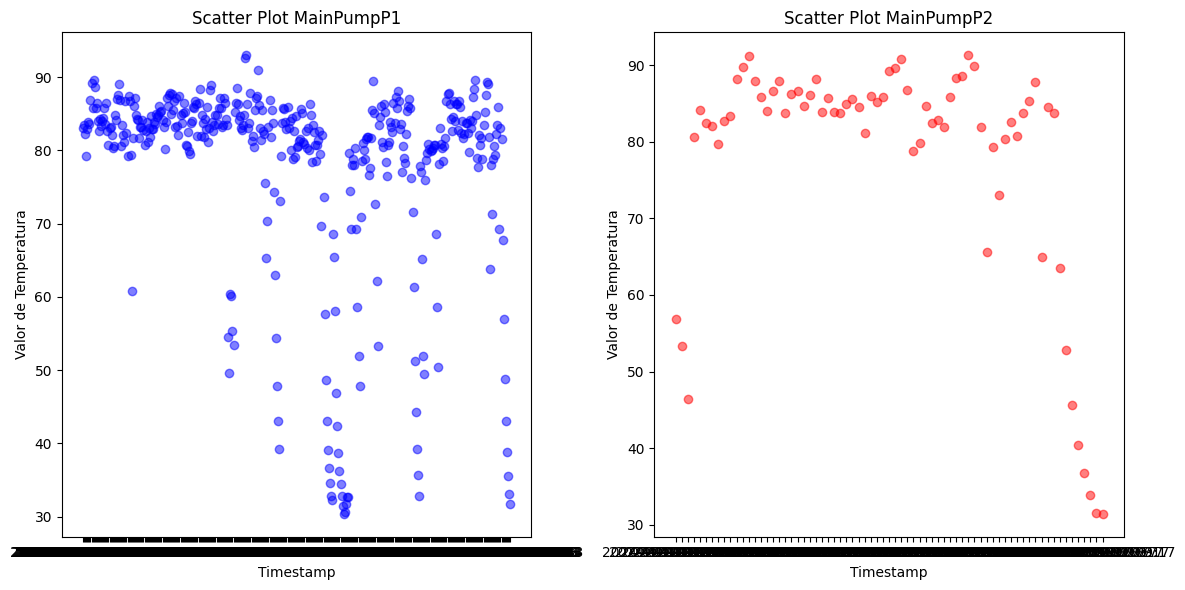

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtrando os dados para componentes que contêm 'Pump' no nome
data_pump = DfDynamoxTemp[DfDynamoxTemp['NmeComp'].str.contains('Pump', case=False, na=False)]

# Filtrando para MainPumpP1 e MainPumpP2, se forem os principais componentes
data_p1 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP1']
data_p2 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP2']

# Configurando o layout dos subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plotando o scatter plot para MainPumpP1
axes[0].scatter(data_p1['Timestamp'], data_p1['temperature'], color='blue', alpha=0.5)
axes[0].set_title('Scatter Plot MainPumpP1')
axes[0].set_xlabel('Timestamp')
axes[0].set_ylabel('Valor de Temperatura')
#axes[0].tick_params(axis='x', rotation=90)  # Rotaciona as labels do eixo X em 90 graus

# Plotando o scatter plot para MainPumpP2
axes[1].scatter(data_p2['Timestamp'], data_p2['temperature'], color='red', alpha=0.5)
axes[1].set_title('Scatter Plot MainPumpP2')
axes[1].set_xlabel('Timestamp')
axes[1].set_ylabel('Valor de Temperatura')
#axes[1].tick_params(axis='x', rotation=90)  # Rotaciona as labels do eixo X em 90 graus


# Ajustando o layout
plt.tight_layout()

# Exibindo os subplots
plt.show()


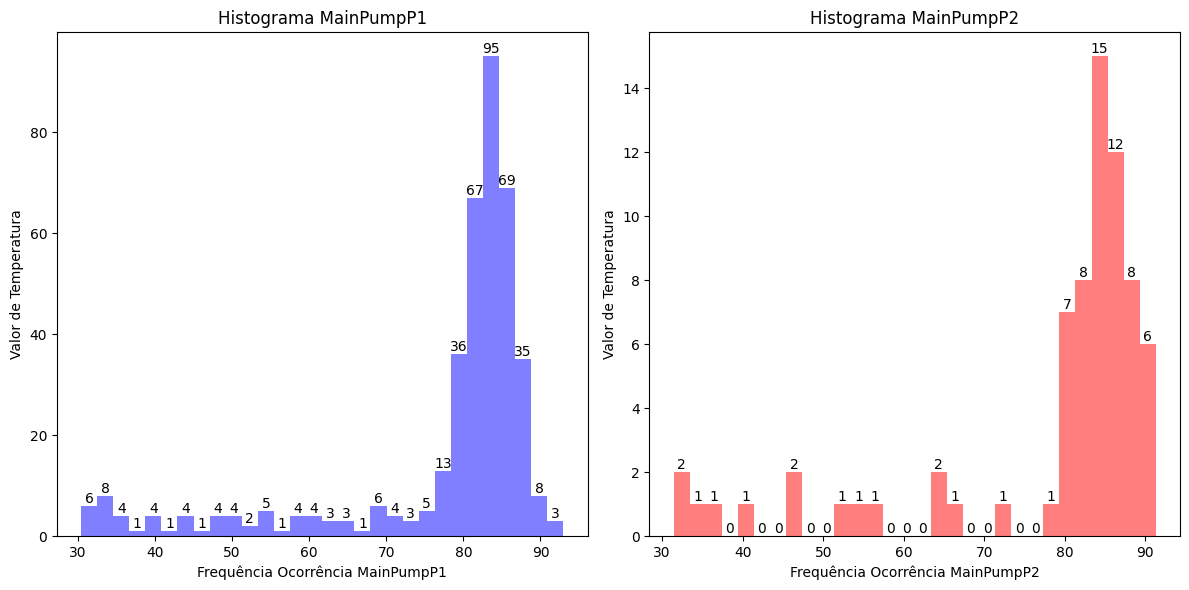

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Filtrando os dados para componentes que contêm 'Pump' no nome
data_pump = DfDynamoxTemp[DfDynamoxTemp['NmeComp'].str.contains('Pump', case=False, na=False)]

# Filtrando para MainPumpP1 e MainPumpP2, se forem os principais componentes
data_p1 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP1']['temperature']
data_p2 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP2']['temperature']

# Configurando o layout dos subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# Plotando o histograma para MainPumpP1
n1, bins1, patches1 = axes[0].hist(data_p1, bins=30, color='blue', alpha=0.5)
axes[0].set_title('Histograma MainPumpP1')
axes[0].set_xlabel('Frequência Ocorrência MainPumpP1')
axes[0].set_ylabel('Valor de Temperatura')
# Adicionando os valores das barras para MainPumpP1
for rect1 in patches1:
    height1 = rect1.get_height()
    axes[0].text(rect1.get_x() + rect1.get_width()/2., height1, '%d' % int(height1),
            ha='center', va='bottom')
# Plotando o histograma para MainPumpP2
n2, bins2, patches2 = axes[1].hist(data_p2, bins=30, color='red', alpha=0.5)
axes[1].set_title('Histograma MainPumpP2')
axes[1].set_xlabel('Frequência Ocorrência MainPumpP2')
axes[1].set_ylabel('Valor de Temperatura')
# Adicionando os valores das barras para MainPumpP2
for rect2 in patches2:
    height2 = rect2.get_height()
    axes[1].text(rect2.get_x() + rect2.get_width()/2., height2, '%d' % int(height2),
            ha='center', va='bottom')
# Ajustando o layout
plt.tight_layout()
# Exibindo os subplots
plt.show()

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Filtrando os dados para componentes que contêm 'Pump' no nome
data_pump = DfDynamoxTemp[DfDynamoxTemp['NmeComp'].str.contains('Pump', case=False, na=False)]

# Filtrando para MainPumpP1 e MainPumpP2, se forem os principais componentes
data_p1 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP1'].dropna(subset=['temperature'])
data_p2 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP2'].dropna(subset=['temperature'])

# Criar subplots com plotly para MainPumpP1 e MainPumpP2
fig_data_pump = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=['MainPumpP1', 'MainPumpP2'])

# Adicionar trace para MainPumpP1 usando a paleta Viridis
fig_data_pump.add_trace(go.Scatter(x=data_p1['Timestamp'], y=data_p1['temperature'],
                                             mode='lines', fill='tozeroy', line=dict(color='rgb(68, 1, 84)'), name='MainPumpP1'),
                                  row=1, col=1)

# Adicionar trace para MainPumpP2 usando a paleta Viridis
fig_data_pump.add_trace(go.Scatter(x=data_p2['Timestamp'], y=data_p2['temperature'],
                                             mode='lines', fill='tozeroy', line=dict(color='rgb(33, 145, 140)'), name='MainPumpP2'),
                                  row=2, col=1)

# Definir o limite máximo para o eixo y como 100 graus para ambos os gráficos
fig_data_pump.update_yaxes(range=[0, 100], row=1, col=1)
fig_data_pump.update_yaxes(range=[0, 100], row=2, col=1)

# Atualizar layout com títulos personalizados e aumentar o tamanho das fontes
fig_data_pump.update_layout(
    title_text='Temperatura MainPumpP1 e MainPumpP2 ao longo do tempo',
    title_font_size=24,  # Tamanho da fonte do título
    height=800,  # Aumentar a altura do gráfico
    xaxis=dict(
        title='Tempo',
        titlefont=dict(size=24),  # Tamanho da fonte do título do eixo x
        tickfont=dict(size=22),  # Tamanho da fonte dos rótulos do eixo x
    ),
    yaxis=dict(
        title='Temperatura (C°)',
        titlefont=dict(size=24),  # Tamanho da fonte do título do eixo y
        tickfont=dict(size=22)  # Tamanho da fonte dos rótulos do eixo y
    ),
    font=dict(size=20)  # Tamanho da fonte para o gráfico inteiro
)

# Ajustar o layout dos subplots
fig_data_pump.update_annotations(font_size=20)  # Tamanho da fonte dos títulos dos subplots

# Exibir o gráfico interativo
fig_data_pump.show()

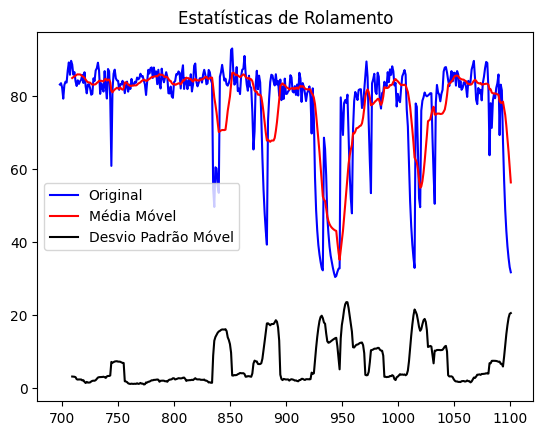

Resultados do Teste Dickey-Fuller:
Estatística do Teste             -5.058512
Valor-p                           0.000017
#Lags Usados                      1.000000
Número de Observações Usadas    402.000000
Valor Crítico (1%)               -3.446722
Valor Crítico (5%)               -2.868757
Valor Crítico (10%)              -2.570614
dtype: float64


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Separação dos dados de temperatura das Bombas P1 e P2
data_p1 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP1']

# Primeiro, vamos filtrar a série temporal desejada (por exemplo, usando a coluna 'Parametro' para selecionar)
serie_temporalP1 = data_p1['temperature']
# Função para testar estacionariedade da série temporal
def test_stationarity(timeseries):
    # Verificar se a série temporal não está vazia
    if timeseries.empty:
        print("Série temporal está vazia.")
        return
    # Estatísticas de rolamento
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    # Plotar estatísticas de rolamento
    import matplotlib.pyplot as plt
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Média Móvel')
    plt.plot(rolstd, color='black', label = 'Desvio Padrão Móvel')
    plt.legend(loc='best')
    plt.title('Estatísticas de Rolamento')
    plt.show()
    # Teste de Dickey-Fuller:
    print('Resultados do Teste Dickey-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estatística do Teste','Valor-p','#Lags Usados','Número de Observações Usadas'])
    for key,value in dftest[4].items():
        dfoutput['Valor Crítico (%s)'%key] = value
    print(dfoutput)
# Aplicar teste de estacionariedade à série temporal selecionada
test_stationarity(serie_temporalP1)

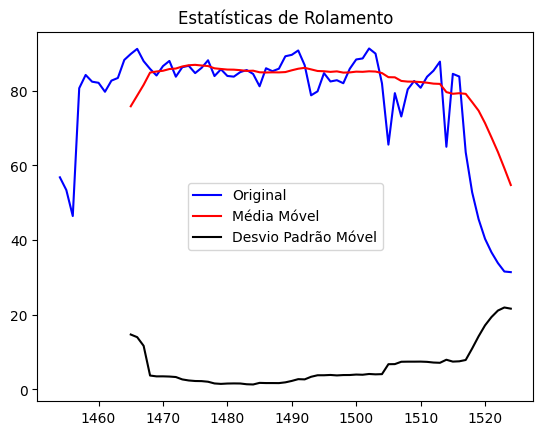

Resultados do Teste Dickey-Fuller:
Estatística do Teste            -1.110442
Valor-p                          0.710890
#Lags Usados                     0.000000
Número de Observações Usadas    70.000000
Valor Crítico (1%)              -3.527426
Valor Crítico (5%)              -2.903811
Valor Crítico (10%)             -2.589320
dtype: float64


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Separação dos dados de temperatura das Bombas P1 e P2
data_p2 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP2']

# Primeiro, vamos filtrar a série temporal desejada (por exemplo, usando a coluna 'Parametro' para selecionar)
serie_temporalP2 = data_p2['temperature']
# Função para testar estacionariedade da série temporal
def test_stationarity(timeseries):
    # Verificar se a série temporal não está vazia
    if timeseries.empty:
        print("Série temporal está vazia.")
        return
    # Estatísticas de rolamento
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    # Plotar estatísticas de rolamento
    import matplotlib.pyplot as plt
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Média Móvel')
    plt.plot(rolstd, color='black', label = 'Desvio Padrão Móvel')
    plt.legend(loc='best')
    plt.title('Estatísticas de Rolamento')
    plt.show()
    # Teste de Dickey-Fuller:
    print('Resultados do Teste Dickey-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estatística do Teste','Valor-p','#Lags Usados','Número de Observações Usadas'])
    for key,value in dftest[4].items():
        dfoutput['Valor Crítico (%s)'%key] = value
    print(dfoutput)
# Aplicar teste de estacionariedade à série temporal selecionada
test_stationarity(serie_temporalP2)

##Modelo SVR para dados de Bomba 1 e Bomba 2

In [ ]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import warnings

# Suprimir avisos específicos
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Separação dos dados de temperatura das Bombas P1 e P2
Df_Pump1 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP1']
Df_Pump2 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP2']


# Converter a coluna 'Timestamp' para o tipo datetime, se necessário
Df_Pump1['Timestamp'] = pd.to_datetime(Df_Pump1['Timestamp'])
Df_Pump2['Timestamp'] = pd.to_datetime(Df_Pump2['Timestamp'])

# Criar o DataFrame para armazenar os resultados
dfEM3401_results_SVR = pd.DataFrame(columns=['Modelo', 'MAE', 'MSE', 'R2', 'RMSE', 'AIC'])

# Função para calcular AIC
def calcular_aic(n, mse, k):
    return n * np.log(mse) + 2 * k

# Função para treinar o modelo SVR e calcular as métricas
def calcular_metrica_SVR(df_pump, modelo_pump_name):
    # Definir as features (X) e o target (y)
    X = df_pump['Timestamp'].view(int).values.reshape(-1, 1)  # Converta o Timestamp para numérico
    y = df_pump['temperature']

    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Treinar o modelo SVR
    svr_model = SVR(kernel='rbf')  # Usando o kernel 'rbf' para SVR
    svr_model.fit(X_train, y_train)

    # Fazer previsões com o modelo SVR
    y_pred_svr = svr_model.predict(X_test)

    # Avaliar o desempenho do modelo SVR
    mae = mean_absolute_error(y_test, y_pred_svr)
    mse = mean_squared_error(y_test, y_pred_svr)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_svr)

    # Calcular o AIC
    n = len(y_test)  # Número de amostras
    k = X_train.shape[1]  # Número de parâmetros (features)
    aic = calcular_aic(n, mse, k)

    # Adicionar as métricas de erro ao DataFrame df_results_SVR
    dfEM3401_results_SVR.loc[len(dfEM3401_results_SVR)] = {'Modelo': modelo_pump_name, 'MAE': mae, 'MSE': mse, 'R2': r2, 'RMSE': rmse, 'AIC': aic}

# Aplicar a função para MainPumpP1
calcular_metrica_SVR(Df_Pump1, 'SVRMainPumpP1')

# Aplicar a função para MainPumpP2
calcular_metrica_SVR(Df_Pump2, 'SVRMainPumpP2')

# Exibir o DataFrame df_results_SVR
print(dfEM3401_results_SVR)


          Modelo       MAE         MSE        R2       RMSE         AIC
0  SVRMainPumpP1  7.995060  221.299033 -0.098627  14.876123  439.360705
1  SVRMainPumpP2  5.137414   59.146620  0.093353   7.690684   63.200292


##Modelo ARIMA para dados de Bomba 1 e Bomba 2

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import warnings

# Suprimir avisos específicos
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)  # Suprimir warnings gerais do StatsModels

# Separação dos dados de temperatura das Bombas P1 e P2
Df_Pump1 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP1']
Df_Pump2 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP2']


# Converter a coluna 'Timestamp' para o tipo datetime, se necessário
Df_Pump1['Timestamp'] = pd.to_datetime(Df_Pump1['Timestamp'])
Df_Pump2['Timestamp'] = pd.to_datetime(Df_Pump2['Timestamp'])

# Criar o DataFrame para armazenar os resultados
dfEM3401_results_ARIMA = pd.DataFrame(columns=['Modelo', 'MAE', 'MSE', 'R2', 'RMSE', 'AIC'])

# Função para treinar o modelo ARIMA e calcular as métricas
def calcular_metrica_ARIMA(df_pump, modelo_pump_name, order=(5, 1, 0)):
    # Definir os dados de treinamento e teste
    train_size = int(len(df_pump) * 0.8)  # 80% dos dados para treinamento
    train_data = df_pump['temperature'].iloc[:train_size]
    test_data = df_pump['temperature'].iloc[train_size:]

    # Ajustar o modelo ARIMA aos dados de treinamento
    model = ARIMA(train_data, order=order)
    arima_model = model.fit()

    # Fazer previsões com o modelo ajustado
    start_index = len(train_data)
    end_index = start_index + len(test_data) - 1
    predictions = arima_model.predict(start=start_index, end=end_index, typ='levels')

    # Calcular as métricas de erro (MAE, MSE, R²)
    mae = mean_absolute_error(test_data, predictions)
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_data, predictions)

    # Calcular o AIC
    aic = arima_model.aic

    # Adicionar as métricas de erro ao DataFrame df_results_ARIMA
    dfEM3401_results_ARIMA.loc[len(dfEM3401_results_ARIMA)] = {
        'Modelo': modelo_pump_name, 'MAE': mae, 'MSE': mse, 'R2': r2, 'RMSE': rmse, 'AIC': aic
    }

# Aplicar a função para MainPumpP1
calcular_metrica_ARIMA(Df_Pump1, 'ARIMAMainPumpP1')

# Aplicar a função para MainPumpP2
calcular_metrica_ARIMA(Df_Pump2, 'ARIMAMainPumpP2')

# Exibir o DataFrame df_results_ARIMA
print(dfEM3401_results_ARIMA)

            Modelo        MAE         MSE        R2       RMSE          AIC
0  ARIMAMainPumpP1  26.845534  778.117570 -3.538283  27.894759  2177.958166
1  ARIMAMainPumpP2  22.750596  805.317195 -0.698433  28.378111   366.199616


##MODELO ARIMA COM BOX-COX

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import boxcox
import numpy as np
import warnings

# Suprimir avisos específicos
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)  # Suprimir warnings gerais do StatsModels


# Separação dos dados de temperatura das Bombas P1 e P2
Df_Pump1 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP1']
Df_Pump2 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP2']


# Converter a coluna 'Timestamp' para o tipo datetime, se necessário
Df_Pump1['Timestamp'] = pd.to_datetime(Df_Pump1['Timestamp'])
Df_Pump2['Timestamp'] = pd.to_datetime(Df_Pump2['Timestamp'])


# Criar o DataFrame para armazenar os resultados
dfEM3401_results_ARIMA = pd.DataFrame(columns=['Modelo', 'MAE', 'MSE', 'R2', 'RMSE', 'AIC'])

# Função para treinar o modelo ARIMA com transformação Box-Cox e calcular as métricas
def calcular_metrica_ARIMA_boxcox(df_pump, modelo_pump_name, order=(5, 1, 0)):
    # Definir os dados de treinamento e teste
    train_size = int(len(df_pump) * 0.8)  # 80% dos dados para treinamento
    train_data = df_pump['temperature'].iloc[:train_size]
    test_data = df_pump['temperature'].iloc[train_size:]

    # Aplicar a transformação de Box-Cox aos dados de treinamento
    train_data_boxcox, lambda_bc = boxcox(train_data + 1e-6)  # Adicionar um pequeno valor para evitar valores zero

    # Ajustar o modelo ARIMA aos dados de treinamento transformados
    model = ARIMA(train_data_boxcox, order=order)
    arima_model = model.fit()

    # Fazer previsões com o modelo ajustado
    start_index = len(train_data)
    end_index = start_index + len(test_data) - 1
    predictions_boxcox = arima_model.predict(start=start_index, end=end_index, typ='levels')

    # Aplicar a transformação inversa de Box-Cox nas previsões
    predictions = np.exp(np.log(lambda_bc * predictions_boxcox + 1) / lambda_bc)

    # Calcular as métricas de erro (MAE, MSE, R²)
    mae = mean_absolute_error(test_data, predictions)
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_data, predictions)

    # Calcular o AIC
    aic = arima_model.aic

    # Adicionar as métricas de erro ao DataFrame df_results_ARIMA
    dfEM3401_results_ARIMA.loc[len(dfEM3401_results_ARIMA)] = {
        'Modelo': modelo_pump_name, 'MAE': mae, 'MSE': mse, 'R2': r2, 'RMSE': rmse, 'AIC': aic
    }

# Aplicar a função para MainPumpP1
calcular_metrica_ARIMA_boxcox(Df_Pump1, 'ARIMAMainPumpP1')

# Aplicar a função para MainPumpP2
calcular_metrica_ARIMA_boxcox(Df_Pump2, 'ARIMAMainPumpP2')

# Exibir o DataFrame df_results_ARIMA
print(dfEM3401_results_ARIMA)


            Modelo        MAE         MSE        R2       RMSE           AIC
0  ARIMAMainPumpP1  20.261796  443.083752 -1.584236  21.049555  15990.294672
1  ARIMAMainPumpP2  23.157908  870.271845 -0.835424  29.500370   3769.687276


## Modelo LSTM para dados de Bomba 1 e Bomba 2

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import logging
import warnings
import os
import tensorflow as tf

# Suprimir avisos específicos
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Configurar TensorFlow para ignorar avisos
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Separação dos dados de temperatura das Bombas P1 e P2
Df_Pump1 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP1']
Df_Pump2 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP2']

# Converter a coluna 'Timestamp' para o tipo datetime, se necessário
Df_Pump1['Timestamp'] = pd.to_datetime(Df_Pump1['Timestamp'])
Df_Pump2['Timestamp'] = pd.to_datetime(Df_Pump2['Timestamp'])

# Inicializar o DataFrame para armazenar os resultados
dfEM3401_results_RNNLSTM = pd.DataFrame(columns=['Modelo', 'MAE', 'MSE', 'R2', 'RMSE', 'AIC'])

# Função para preparar os dados em sequências para LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Função para calcular AIC
def calculate_aic(n, mse, k):
    return n * np.log(mse) + 2 * k

# Função para treinar o modelo LSTM e calcular as métricas
def calcular_metrica_LSTM(df_pump, modelo_pump_name, seq_length=10):
    # Normalizar os dados
    scaler = MinMaxScaler()
    df_pump['temperature'] = scaler.fit_transform(df_pump[['temperature']])

    # Criar sequências de dados
    X, y = create_sequences(df_pump['temperature'].values, seq_length)

    # Redimensionar os dados de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Construir o modelo LSTM
    model = Sequential([
        LSTM(units=15, input_shape=(X_train.shape[1], 1)),
        Dense(1)
    ])

    # Compilar o modelo
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Treinar o modelo
    model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=0)

    # Fazer previsões
    predictions = model.predict(X_test)

    # Calcular as métricas de erro
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    # Calcular o número de parâmetros no modelo (aproximadamente para AIC)
    k = model.count_params()
    n = len(y_test)
    aic = calculate_aic(n, mse, k)

    # Adicionar as métricas de erro ao DataFrame df_results_RNNLSTM
    dfEM3401_results_RNNLSTM.loc[len(dfEM3401_results_RNNLSTM)] = {'Modelo': modelo_pump_name, 'MAE': mae, 'MSE': mse, 'R2': r2, 'RMSE': rmse, 'AIC': aic}

# Aplicar a função para MainPumpP1
calcular_metrica_LSTM(Df_Pump1, 'RNNLSTMMainPumpP1')

# Aplicar a função para MainPumpP2
calcular_metrica_LSTM(Df_Pump2, 'RNNLSTMMainPumpP2')

# Exibir o DataFrame df_results_RNNLSTM
print(dfEM3401_results_RNNLSTM)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
              Modelo       MAE       MSE        R2      RMSE          AIC
0  RNNLSTMMainPumpP1  0.082152  0.016965  0.566951  0.130248  1749.946789
1  RNNLSTMMainPumpP2  0.216836  0.067091  0.165992  0.259020  2036.877870


##Modelo GRU para dados de Bomba 1 e Bomba 2

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import logging
import warnings
import os

# Suprimir avisos específicos
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Configurar TensorFlow para ignorar avisos
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)

# Configurar logging para absl
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Separação dos dados de temperatura das Bombas P1 e P2
Df_Pump1 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP1']
Df_Pump2 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP2']

# Converter a coluna 'Timestamp' para o tipo datetime, se necessário
Df_Pump1['Timestamp'] = pd.to_datetime(Df_Pump1['Timestamp'])
Df_Pump2['Timestamp'] = pd.to_datetime(Df_Pump2['Timestamp'])

# Inicializar o DataFrame para armazenar os resultados
dfEM3401_results_RNNGRU = pd.DataFrame(columns=['Modelo', 'MAE', 'MSE', 'R2', 'AIC', 'RMSE'])

# Função para preparar os dados em sequências para GRU
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Função para calcular o AIC
def calculate_aic(n, mse, k):
    return n * np.log(mse) + 2 * k

# Função para treinar o modelo GRU e calcular as métricas
def calcular_metrica_GRU(df_pump, modelo_pump_name, seq_length=10):
    # Normalizar os dados
    scaler = MinMaxScaler()
    df_pump['temperature'] = scaler.fit_transform(df_pump[['temperature']])

    # Criar sequências de dados
    X, y = create_sequences(df_pump['temperature'].values, seq_length)

    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Reshape X to be compatible with GRU: (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Construir o modelo GRU
    model = Sequential([
        GRU(units=15, input_shape=(X_train.shape[1], 1)),
        Dense(1)
    ])

    # Compilar o modelo
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Treinar o modelo
    model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=0)

    # Fazer previsões
    predictions = model.predict(X_test)

    # Inverter a normalização nas previsões e valores reais
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calcular as métricas de erro
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    rmse = np.sqrt(mse)  # RMSE is simply the square root of MSE

    # Calcular AIC
    n = len(y_test)  # número de observações
    k = model.count_params()  # número de parâmetros treináveis no modelo
    aic = calculate_aic(n, mse, k)

    # Adicionar as métricas de erro ao DataFrame df_results_RNNGRU
    dfEM3401_results_RNNGRU.loc[len(dfEM3401_results_RNNGRU)] = {'Modelo': modelo_pump_name, 'MAE': mae, 'MSE': mse, 'R2': r2, 'AIC': aic, 'RMSE': rmse}

# Aplicar a função para MainPumpP1
calcular_metrica_GRU(Df_Pump1, 'RNNGRUMainPumpP1')

# Aplicar a função para MainPumpP2
calcular_metrica_GRU(Df_Pump2, 'RNNGRUMainPumpP2')

# Exibir o DataFrame df_results_RNNGRU
print(dfEM3401_results_RNNGRU)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
             Modelo       MAE         MSE        R2          AIC       RMSE
0  RNNGRUMainPumpP1  4.482815   43.884564  0.713826  1950.743448   6.624543
1  RNNGRUMainPumpP2  9.858115  141.150054  0.511161  1716.347706  11.880659


##Modelo SARIMA para dados de Bomba 1 e Bomba 2

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import logging
import warnings
import os

# Suprimir avisos específicos
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Configurar TensorFlow para ignorar avisos (caso TensorFlow esteja envolvido)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Separação dos dados de temperatura das Bombas P1 e P2
Df_Pump1 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP1']
Df_Pump2 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP2']

# Converter a coluna 'Timestamp' para o tipo datetime, se necessário
Df_Pump1['Timestamp'] = pd.to_datetime(Df_Pump1['Timestamp'])
Df_Pump2['Timestamp'] = pd.to_datetime(Df_Pump2['Timestamp'])

# Inicializar o DataFrame para armazenar os resultados
dfEM3401_results_SARIMAX = pd.DataFrame(columns=['Modelo', 'MAE', 'MSE', 'RMSE', 'AIC', 'R2'])

# Função para ajustar o modelo SARIMAX e calcular as métricas
def calcular_metrica_SARIMAX(df_pump, modelo_pump_name, order=(1, 0, 1), seasonal_order=(1, 1, 1, 12)):
    # Ajustar o modelo SARIMAX aos dados de temperatura
    model = SARIMAX(df_pump['temperature'], order=order, seasonal_order=seasonal_order)
    sarimax_model = model.fit()

    # Fazer previsões com o modelo ajustado
    predictions = sarimax_model.predict(start=len(df_pump), end=len(df_pump) + len(df_pump) - 1)

    # Calcular as métricas de erro (MAE, MSE, RMSE, AIC, R²)
    mae = mean_absolute_error(df_pump['temperature'][-len(predictions):], predictions)
    mse = mean_squared_error(df_pump['temperature'][-len(predictions):], predictions)
    rmse = np.sqrt(mse)
    aic = sarimax_model.aic
    r2 = r2_score(df_pump['temperature'][-len(predictions):], predictions)

    # Adicionar as métricas de erro ao DataFrame df_results_SARIMAX
    dfEM3401_results_SARIMAX.loc[len(dfEM3401_results_SARIMAX)] = {'Modelo': modelo_pump_name, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'AIC': aic, 'R2': r2}

# Aplicar a função para MainPumpP1
calcular_metrica_SARIMAX(Df_Pump1, 'SARIMAXMainPumpP1')

# Aplicar a função para MainPumpP2
calcular_metrica_SARIMAX(Df_Pump2, 'SARIMAXMainPumpP2')

# Exibir o DataFrame df_results_SARIMAX
print(dfEM3401_results_SARIMAX)

              Modelo         MAE           MSE        RMSE          AIC  \
0  SARIMAXMainPumpP1   10.759091    227.362922   15.078558  2666.442564   
1  SARIMAXMainPumpP2  102.591022  11294.219668  106.274266   425.831430   

          R2  
0  -0.157622  
1 -46.060166  


##Modelo RLM para dados de Bomba 1 e Bomba 2

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
import os
import numpy as np

# Suprimir avisos específicos
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Configurar TensorFlow para ignorar avisos (caso TensorFlow esteja envolvido)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Função para calcular o AIC
def calcular_aic(n, mse, k):
    return n * np.log(mse / n) + 2 * k

# Separação dos dados de temperatura das Bombas P1 e P2
Df_Pump1 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP1']
Df_Pump2 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP2']

# Converter a coluna 'Timestamp' para o tipo datetime, se necessário
Df_Pump1['Timestamp'] = pd.to_datetime(Df_Pump1['Timestamp'])
Df_Pump2['Timestamp'] = pd.to_datetime(Df_Pump2['Timestamp'])

# Converter a coluna 'Timestamp' para um formato numérico (por exemplo, número de dias desde o início da época)
Df_Pump1['NumericTimestamp'] = Df_Pump1['Timestamp'].astype('int64') / 10**9 / 86400  # Converter nanossegundos para dias
Df_Pump2['NumericTimestamp'] = Df_Pump2['Timestamp'].astype('int64') / 10**9 / 86400  # Converter nanossegundos para dias

# Inicializar o DataFrame para armazenar os resultados
dfEM3401_results_RLM = pd.DataFrame(columns=['Modelo', 'MAE', 'MSE', 'RMSE', 'AIC', 'R2'])

# Função para treinar o modelo de Regressão Linear Múltipla e calcular as métricas
def calcular_metrica_RLM(df_pump, modelo_pump_name):
    # Definir as features (X) e o target (y)
    X = df_pump[['NumericTimestamp']]  # Feature é o timestamp numérico
    y = df_pump['temperature']

    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Ajustar o modelo de regressão linear aos dados de treinamento
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Fazer previsões com o modelo ajustado
    y_pred = model.predict(X_test)

    # Calcular as métricas de erro (MAE, MSE, RMSE, AIC, R²)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Calcular o número de parâmetros (número de características + 1 para o bias)
    n_params = X_train.shape[1] + 1

    # Calcular o AIC
    aic = calcular_aic(len(y_test), mse, n_params)

    # Calcular R2
    r2 = r2_score(y_test, y_pred)

    # Adicionar as métricas de erro ao DataFrame df_results_RLM
    dfEM3401_results_RLM.loc[len(dfEM3401_results_RLM)] = {'Modelo': modelo_pump_name, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'AIC': aic, 'R2': r2}

# Aplicar a função para MainPumpP1
calcular_metrica_RLM(Df_Pump1, 'RLMMainPumpP1')

# Aplicar a função para MainPumpP2
calcular_metrica_RLM(Df_Pump2, 'RLMMainPumpP2')

# Exibir o DataFrame df_results_RLM
print(dfEM3401_results_RLM)

          Modelo       MAE         MSE       RMSE        AIC        R2
0  RLMMainPumpP1  8.754171  185.264628  13.611195  71.014222  0.080264
1  RLMMainPumpP2  8.936597  156.307716  12.502308  39.156646 -1.396011


##Junção de todos os Data Frames

In [ ]:
import pandas as pd

# Suponha que você tenha os DataFrames contendo os resultados de diferentes modelos
dfEM3401_results = pd.concat([dfEM3401_results_SARIMAX,
                        dfEM3401_results_RNNGRU,
                        dfEM3401_results_RNNLSTM,
                        dfEM3401_results_RLM,
                        dfEM3401_results_ARIMA,
                        dfEM3401_results_SVR
                        ], ignore_index=True)
# Exibir o DataFrame resultante
dfEM3401_results.head(100)

,Modelo,MAE,MSE,RMSE,AIC,R2
0,SARIMAXMainPumpP1,10.759091,227.362922,15.078558,2666.442564,-0.157622
1,SARIMAXMainPumpP2,102.591022,11294.219668,106.274266,425.831430,-46.060166
2,RNNGRUMainPumpP1,4.482815,43.884564,6.624543,1950.743448,0.713826
3,RNNGRUMainPumpP2,9.858115,141.150054,11.880659,1716.347706,0.511161
4,RNNLSTMMainPumpP1,0.082152,0.016965,0.130248,1749.946789,0.566951
5,RNNLSTMMainPumpP2,0.216836,0.067091,0.259020,2036.877870,0.165992
6,RLMMainPumpP1,8.754171,185.264628,13.611195,71.014222,0.080264
7,RLMMainPumpP2,8.936597,156.307716,12.502308,39.156646,-1.396011
8,ARIMAMainPumpP1,20.261796,443.083752,21.049555,15990.294672,-1.584236
9,ARIMAMainPumpP2,23.157908,870.271845,29.500370,3769.687276,-0.835424


##Ranking dos resultados MAE, MAE, MSE, R2, AIC e RMSE

In [ ]:
import pandas as pd

# Supondo que df_results tenha os resultados de ambas as bombas (MainPumpP1 e MainPumpP2)

# Filtrar os resultados por MainPumpP1 e MainPumpP2
dfEM3401_resultsP1 = dfEM3401_results[dfEM3401_results['Modelo'].str.contains('PumpP1')]
dfEM3401_resultsP2 = dfEM3401_results[dfEM3401_results['Modelo'].str.contains('PumpP2')]

# Função para classificar os modelos separadamente por MAE, MSE, R², AIC, e RMSE e calcular o Total_rank
def classificar_modelos(df, pump_name):
    # Classificar os modelos separadamente por MAE, MSE, R², AIC, e RMSE
    df[f'MAE_rank_{pump_name}'] = df['MAE'].rank(ascending=True)
    df[f'MSE_rank_{pump_name}'] = df['MSE'].rank(ascending=True)
    df[f'R2_rank_{pump_name}'] = df['R2'].rank(ascending=False)
    df[f'AIC_rank_{pump_name}'] = df['AIC'].rank(ascending=True)
    df[f'RMSE_rank_{pump_name}'] = df['RMSE'].rank(ascending=True)

    # Soma dos ranks para cada modelo
    df[f'Total_rank_{pump_name}'] = df[f'MAE_rank_{pump_name}'] + df[f'MSE_rank_{pump_name}'] + \
                                    df[f'R2_rank_{pump_name}'] + df[f'AIC_rank_{pump_name}'] + \
                                    df[f'RMSE_rank_{pump_name}']

    # Ordenar pelo rank total (quanto menor, melhor)
    df_sorted = df.sort_values(by=f'Total_rank_{pump_name}')

    return df_sorted

# Classificar e ordenar os modelos para MainPumpP1
df_sorted_pump1 = classificar_modelos(dfEM3401_resultsP1, 'PumpP1')

# Classificar e ordenar os modelos para MainPumpP2
df_sorted_pump2 = classificar_modelos(dfEM3401_resultsP2, 'PumpP2')

In [ ]:
df_sorted_pump1.head(100)

,Modelo,MAE,MSE,RMSE,AIC,R2,MAE_rank_PumpP1,MSE_rank_PumpP1,R2_rank_PumpP1,AIC_rank_PumpP1,RMSE_rank_PumpP1,Total_rank_PumpP1
4,RNNLSTMMainPumpP1,0.082152,0.016965,0.130248,1749.946789,0.566951,1.0,1.0,2.0,3.0,1.0,8.0
2,RNNGRUMainPumpP1,4.482815,43.884564,6.624543,1950.743448,0.713826,2.0,2.0,1.0,4.0,2.0,11.0
6,RLMMainPumpP1,8.754171,185.264628,13.611195,71.014222,0.080264,4.0,3.0,3.0,1.0,3.0,14.0
10,SVRMainPumpP1,7.995060,221.299033,14.876123,439.360705,-0.098627,3.0,4.0,4.0,2.0,4.0,17.0
0,SARIMAXMainPumpP1,10.759091,227.362922,15.078558,2666.442564,-0.157622,5.0,5.0,5.0,5.0,5.0,25.0
8,ARIMAMainPumpP1,20.261796,443.083752,21.049555,15990.294672,-1.584236,6.0,6.0,6.0,6.0,6.0,30.0


In [ ]:
df_sorted_pump2.head(100)

,Modelo,MAE,MSE,RMSE,AIC,R2,MAE_rank_PumpP2,MSE_rank_PumpP2,R2_rank_PumpP2,AIC_rank_PumpP2,RMSE_rank_PumpP2,Total_rank_PumpP2
5,RNNLSTMMainPumpP2,0.216836,0.067091,0.259020,2036.877870,0.165992,1.0,1.0,2.0,5.0,1.0,10.0
11,SVRMainPumpP2,5.137414,59.146620,7.690684,63.200292,0.093353,2.0,2.0,3.0,2.0,2.0,11.0
3,RNNGRUMainPumpP2,9.858115,141.150054,11.880659,1716.347706,0.511161,4.0,3.0,1.0,4.0,3.0,15.0
7,RLMMainPumpP2,8.936597,156.307716,12.502308,39.156646,-1.396011,3.0,4.0,5.0,1.0,4.0,17.0
9,ARIMAMainPumpP2,23.157908,870.271845,29.500370,3769.687276,-0.835424,5.0,5.0,4.0,6.0,5.0,25.0
1,SARIMAXMainPumpP2,102.591022,11294.219668,106.274266,425.831430,-46.060166,6.0,6.0,6.0,3.0,6.0,27.0


##Analise dos residuos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.preprocessing import MinMaxScaler
import warnings
from scipy.stats import shapiro

warnings.filterwarnings("ignore")

# Parâmetros fornecidos
melhores_parametros = {'C': 1.0, 'epsilon': 0.1, 'kernel': 'rbf'}

# Função para criar lags para a coluna target
def criar_lags(df, target_column='temperature', lags=3):
    df_lags = df.copy()
    for lag in range(1, lags + 1):
        df_lags[f'lag_{lag}'] = df_lags[target_column].shift(lag)
    df_lags = df_lags.dropna()  # Remove as primeiras linhas com NaN causadas pelos lags
    return df_lags

# Separação dos dados de temperatura das Bombas P1 e P2
Df_Pump1 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP1']
Df_Pump2 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP2']

# Converter a coluna 'Timestamp' para o tipo datetime, se necessário
Df_Pump1['Timestamp'] = pd.to_datetime(Df_Pump1['Timestamp'])
Df_Pump2['Timestamp'] = pd.to_datetime(Df_Pump2['Timestamp'])

# Função para preparar os dados (criar lags e separar features e target)
def preparar_dados_com_lags(df, target_column='temperature', lags=3):
    df_lags = criar_lags(df, target_column=target_column, lags=lags)
    X = df_lags[[f'lag_{i}' for i in range(1, lags + 1)]]
    y = df_lags[target_column]
    return X, y

# Preparar os dados para as bombas P1 e P2 com lags 1, 2 e 3
X_p1, y_p1 = preparar_dados_com_lags(Df_Pump1)
X_p2, y_p2 = preparar_dados_com_lags(Df_Pump2)

# Normalizar os dados para LSTM e GRU
scaler_p1 = MinMaxScaler()
X_p1_scaled = scaler_p1.fit_transform(X_p1)

scaler_p2 = MinMaxScaler()
X_p2_scaled = scaler_p2.fit_transform(X_p2)

# Função para dividir os dados em treino e teste
def dividir_treino_teste(X, y, split_ratio=0.8):
    train_size = int(len(X) * split_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

# Dividir os dados em treino e teste para P1 e P2
X_train_p1, X_test_p1, y_train_p1, y_test_p1 = dividir_treino_teste(X_p1_scaled, y_p1)
X_train_p2, X_test_p2, y_train_p2, y_test_p2 = dividir_treino_teste(X_p2_scaled, y_p2)

# Função para calcular resíduos
def calcular_residuos(y_true, y_pred):
    return y_true - y_pred

### Função para treinar e avaliar os modelos ###
def treinar_e_avaliar_modelos(X_train, X_test, y_train, y_test, modelo_nome, melhores_parametros):
    # LSTM
    model_lstm = Sequential()
    model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer='adam', loss='mse')

    X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model_lstm.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=0)
    y_pred_lstm = model_lstm.predict(X_test_lstm)
    residuos_lstm = calcular_residuos(y_test, y_pred_lstm.flatten())

    # GRU
    model_gru = Sequential()
    model_gru.add(GRU(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model_gru.add(Dense(1))
    model_gru.compile(optimizer='adam', loss='mse')

    model_gru.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=0)
    y_pred_gru = model_gru.predict(X_test_lstm)
    residuos_gru = calcular_residuos(y_test, y_pred_gru.flatten())

    # SVR
    svr = SVR(kernel='rbf')
    svr.fit(X_train, y_train)
    y_pred_svr = svr.predict(X_test)
    residuos_svr = calcular_residuos(y_test, y_pred_svr)

    # SVR ajustado com os melhores parâmetros fornecidos
    svr_ajus = SVR(kernel=melhores_parametros['kernel'], C=melhores_parametros['C'], epsilon=melhores_parametros['epsilon'])
    svr_ajus.fit(X_train, y_train)
    y_pred_svr_ajus = svr_ajus.predict(X_test)
    residuos_svr_ajus = calcular_residuos(y_test, y_pred_svr_ajus)

    # Criar DataFrames de resíduos
    df_residuos = {
        'GRU': pd.DataFrame({'residuos': residuos_gru}),
        'SVM': pd.DataFrame({'residuos': residuos_svr}),
        'LSTM': pd.DataFrame({'residuos': residuos_lstm}),
        'SVR_Ajus': pd.DataFrame({'residuos': residuos_svr_ajus}),
    }

    return df_residuos

# Treinar e avaliar os modelos para P1 e P2 com os melhores parâmetros fornecidos
dfEM3401_residuos_p1 = treinar_e_avaliar_modelos(X_train_p1, X_test_p1, y_train_p1, y_test_p1, 'MainPumpP1', melhores_parametros)
dfEM3401_residuos_p2 = treinar_e_avaliar_modelos(X_train_p2, X_test_p2, y_train_p2, y_test_p2, 'MainPumpP2', melhores_parametros)

# Combinar os DataFrames de resíduos em um único DataFrame para P1 e P2
dfEM3401_residuos_p1_total = pd.concat(dfEM3401_residuos_p1.values(), axis=1, keys=df_residuos_p1.keys())
dfEM3401_residuos_p2_total = pd.concat(dfEM3401_residuos_p2.values(), axis=1, keys=df_residuos_p2.keys())

# Salvar os DataFrames de resíduos combinados
dfEM3401_residuos_p1_total.to_csv('dfEM3401_residuos_p1_total.csv', index=False)
dfEM3401_residuos_p2_total.to_csv('dfEM3401_residuos_p2_total.csv', index=False)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Teste de Shapiro-Wilk para GRU - MainPumpP1:
Estatística=0.9020952594465217, p-valor=1.3371730524682413e-05

Teste de Shapiro-Wilk para LSTM - MainPumpP1:
Estatística=0.8588770484519533, p-valor=2.847799888694082e-07

Teste de Shapiro-Wilk para SVM - MainPumpP1:
Estatística=0.8936127344872925, p-valor=5.886581792110172e-06

Teste de Shapiro-Wilk para SVR_Ajus - MainPumpP1:
Estatística=0.8936127344872925, p-valor=5.886581792110172e-06

Teste de Shapiro-Wilk para GRU - MainPumpP2:
Estatística=0.83772818038793, p-valor=0.015197075368737727

Teste de Shapiro-Wilk para LSTM - MainPumpP2:
Estatística=0.8365551356197587, p-valor=0.014662267602221276

Teste de Shapiro-Wilk para SVM - MainPumpP2:
Estatística=0.8501424633390124, p-valor=0.022309440220138095

Teste de Shapiro-Wilk para SVR_Ajus - MainPumpP2:
Estatística=0.8501424633390124, p-valor=0.022309440220138095

### Histogramas dos Resíduos - MainPumpP1 ###


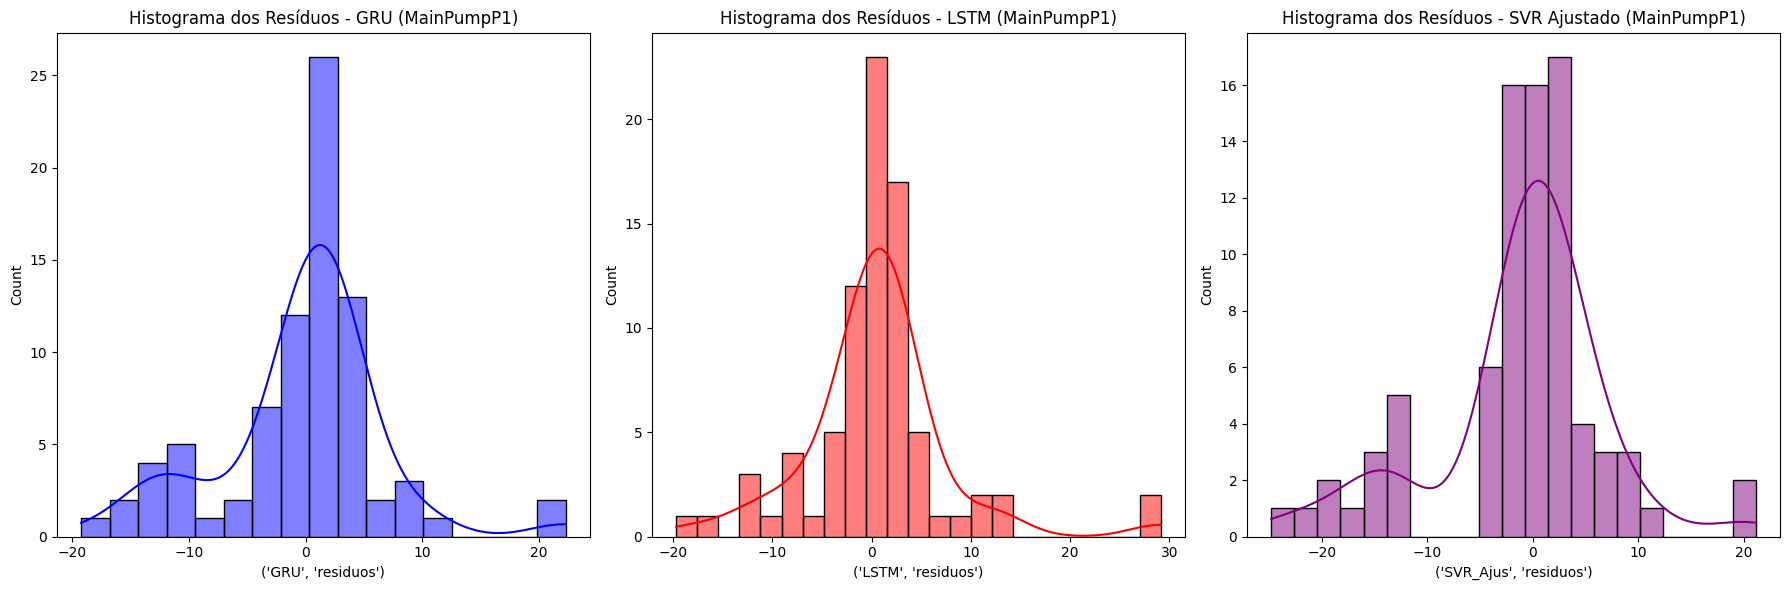

### Histogramas dos Resíduos - MainPumpP2 ###


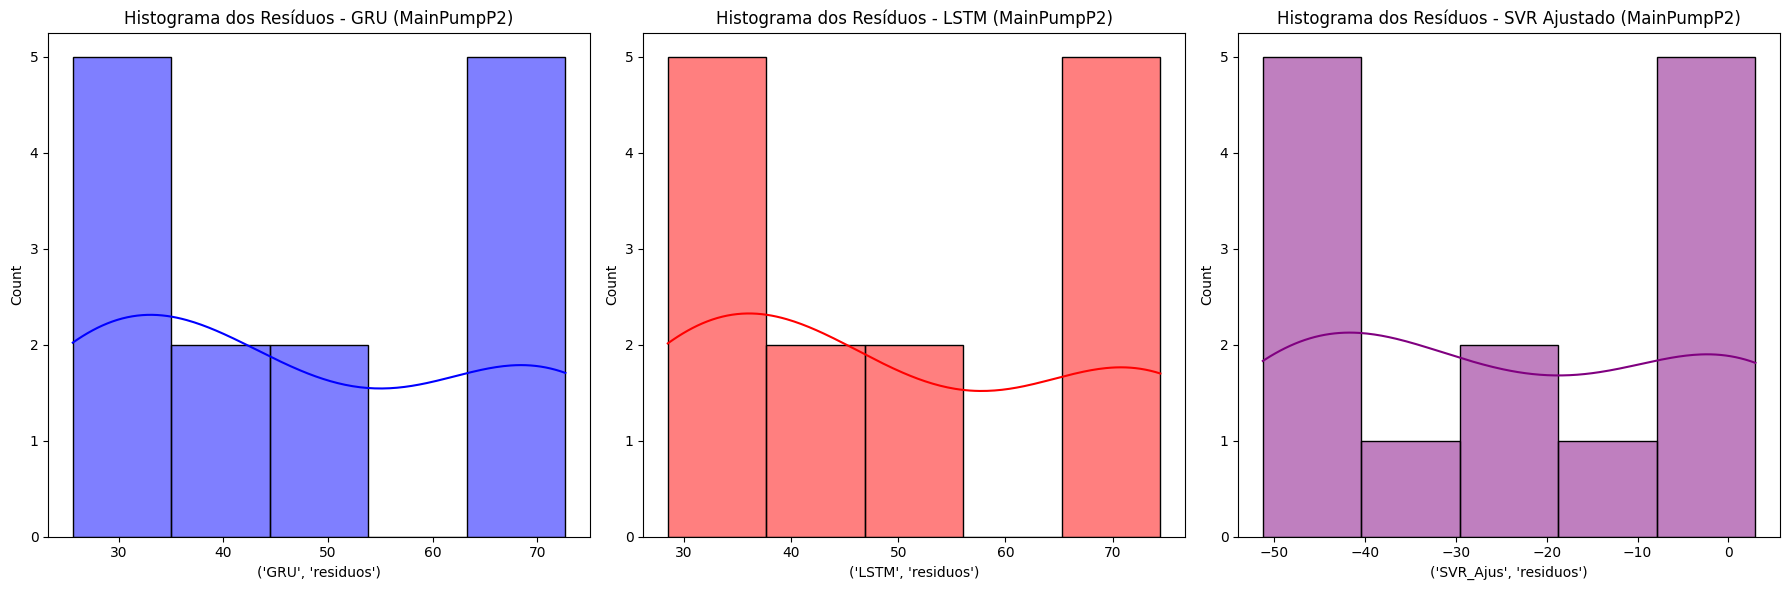

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

# Carregar os DataFrames de resíduos combinados a partir dos arquivos CSV já salvos
dfEM3401_residuos_p1_total = pd.read_csv('dfEM3401_residuos_p1_total.csv', header=[0, 1])  # Especificar header para múltiplos níveis de coluna
dfEM3401_residuos_p2_total = pd.read_csv('dfEM3401_residuos_p2_total.csv', header=[0, 1])

# Função para plotar histogramas dos resíduos
def plotar_histogramas_residuos_combinados(df_residuos_total, modelo_nome):
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    sns.histplot(df_residuos_total['GRU', 'residuos'], kde=True, color='blue')
    plt.title(f'Histograma dos Resíduos - GRU ({modelo_nome})')

    plt.subplot(1, 3, 2)
    sns.histplot(df_residuos_total['LSTM', 'residuos'], kde=True, color='red')
    plt.title(f'Histograma dos Resíduos - LSTM ({modelo_nome})')

    plt.subplot(1, 3, 3)
    sns.histplot(df_residuos_total['SVR_Ajus', 'residuos'], kde=True, color='purple')
    plt.title(f'Histograma dos Resíduos - SVR Ajustado ({modelo_nome})')

    plt.tight_layout()
    plt.show()

# Função para realizar o teste de Shapiro-Wilk e exibir o resultado
def analisar_residuos_shapiro(df_residuos_total, modelo_nome):
    resultados_shapiro = {}
    for model in df_residuos_total.columns.levels[0]:
        residuos = df_residuos_total[model, 'residuos']
        stat, p_value = shapiro(residuos)
        resultados_shapiro[model] = {'Estatística': stat, 'P-valor': p_value}
        print(f'Teste de Shapiro-Wilk para {model} - {modelo_nome}:')
        print(f'Estatística={stat}, p-valor={p_value}\n')
    return resultados_shapiro

# Função para interpretar os resultados do teste de Shapiro-Wilk
def interpretar_resultados_shapiro(resultados_shapiro, alpha=0.05):
    for model, resultado in resultados_shapiro.items():
        p_value = resultado['P-valor']
        if p_value > alpha:
            print(f"Os resíduos do modelo {model} seguem uma distribuição normal (p-valor={p_value:.4f} > {alpha})")
        else:
            print(f"Os resíduos do modelo {model} NÃO seguem uma distribuição normal (p-valor={p_value:.4f} <= {alpha})")

# Calcular os resultados do teste de Shapiro-Wilk para MainPumpP1
resultados_shapiro_p1 = analisar_residuos_shapiro(dfEM3401_residuos_p1_total, 'MainPumpP1')

# Calcular os resultados do teste de Shapiro-Wilk para MainPumpP2
resultados_shapiro_p2 = analisar_residuos_shapiro(dfEM3401_residuos_p2_total, 'MainPumpP2')

# Plotar os histogramas dos resíduos para MainPumpP1
print("### Histogramas dos Resíduos - MainPumpP1 ###")
plotar_histogramas_residuos_combinados(dfEM3401_residuos_p1_total, 'MainPumpP1')

# Plotar os histogramas dos resíduos para MainPumpP2
print("### Histogramas dos Resíduos - MainPumpP2 ###")
plotar_histogramas_residuos_combinados(dfEM3401_residuos_p2_total, 'MainPumpP2')


## Transformações: Box-Cox para modelos LSTM, SVR e GRU:

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Separação dos dados de temperatura das Bombas P1 e P2
Df_Pump1 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP1']
Df_Pump2 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP2']

# Converter a coluna 'Timestamp' para o tipo datetime, se necessário
Df_Pump1['Timestamp'] = pd.to_datetime(Df_Pump1['Timestamp'])
Df_Pump2['Timestamp'] = pd.to_datetime(Df_Pump2['Timestamp'])

# Função para calcular o AIC para modelos de aprendizado de máquina
def calcular_aic(n, residuais, num_params):
    resid_sum_sq = np.sum(residuais ** 2)
    aic = n * np.log(resid_sum_sq / n) + 2 * num_params
    return aic

# Função para aplicar a transformação Box-Cox
def aplicar_boxcox(df_pump, pump_name):
    df_pump.set_index('Timestamp', inplace=True)
    serie_temporal = df_pump['temperature']

    # Aplicar a transformação Box-Cox
    serie_transformada, lam = boxcox(serie_temporal + 1)  # Adicionar 1 para evitar valores zero
    print(f'Transformação Box-Cox aplicada a {pump_name}, lambda: {lam}')

    return serie_transformada, lam

# Função para reverter a transformação Box-Cox
def reverter_boxcox(serie_transformada, lam):
    if lam == 0:
        return np.exp(serie_transformada) - 1
    else:
        return np.power(serie_transformada * lam + 1, 1/lam) - 1

# Função para preparar dados para LSTM/GRU
def preparar_dados(series, n_steps):
    X, y = [], []
    for i in range(len(series) - n_steps):
        X.append(series[i:i+n_steps])
        y.append(series[i+n_steps])
    return np.array(X), np.array(y)

# Função para aplicar LSTM, GRU e SVR e calcular as métricas
def aplicar_modelos(df_pump, pump_name, lam, serie_transformada):
    scaler = MinMaxScaler()
    serie_escalada = scaler.fit_transform(serie_transformada.reshape(-1, 1))

    n_steps = 10
    X, y = preparar_dados(serie_escalada, n_steps)

    # Dividir em treino e teste
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Modelo LSTM
    model_lstm = Sequential()
    model_lstm.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer='adam', loss='mse')
    model_lstm.fit(X_train, y_train, epochs=25, verbose=0)
    y_pred_lstm = model_lstm.predict(X_test)

    # Modelo GRU
    model_gru = Sequential()
    model_gru.add(GRU(50, activation='relu', input_shape=(n_steps, 1)))
    model_gru.add(Dense(1))
    model_gru.compile(optimizer='adam', loss='mse')
    model_gru.fit(X_train, y_train, epochs=25, verbose=0)
    y_pred_gru = model_gru.predict(X_test)

    # Modelo SVR com os melhores parâmetros
    best_params = {'C': 1.0, 'epsilon': 0.1, 'kernel': 'rbf'}  # Substitua pelos parâmetros adequados
    svr_model = SVR(**best_params)
    X_train_svr = X_train.reshape((X_train.shape[0], -1))
    X_test_svr = X_test.reshape((X_test.shape[0], -1))
    svr_model.fit(X_train_svr, y_train.ravel())
    y_pred_svr = svr_model.predict(X_test_svr)

    # Reverter a transformação Box-Cox nas previsões e valores reais
    y_test_inverso = reverter_boxcox(scaler.inverse_transform(y_test.reshape(-1, 1)).flatten(), lam)
    y_pred_lstm_inverso = reverter_boxcox(scaler.inverse_transform(y_pred_lstm).flatten(), lam)
    y_pred_gru_inverso = reverter_boxcox(scaler.inverse_transform(y_pred_gru).flatten(), lam)
    y_pred_svr = scaler.inverse_transform(y_pred_svr.reshape(-1, 1)).flatten()  # Reescalando previsões do SVR
    y_pred_svr_inverso = reverter_boxcox(y_pred_svr, lam)  # Aplicando reversão de Box-Cox

    # Calcular métricas de erro
    mae_lstm = mean_absolute_error(y_test_inverso, y_pred_lstm_inverso)
    mse_lstm = mean_squared_error(y_test_inverso, y_pred_lstm_inverso)
    rmse_lstm = np.sqrt(mse_lstm)
    aic_lstm = calcular_aic(len(y_test_inverso), y_test_inverso - y_pred_lstm_inverso, 50)  # 50 parâmetros para LSTM

    mae_gru = mean_absolute_error(y_test_inverso, y_pred_gru_inverso)
    mse_gru = mean_squared_error(y_test_inverso, y_pred_gru_inverso)
    rmse_gru = np.sqrt(mse_gru)
    aic_gru = calcular_aic(len(y_test_inverso), y_test_inverso - y_pred_gru_inverso, 50)  # 50 parâmetros para GRU

    mae_svr = mean_absolute_error(y_test_inverso, y_pred_svr_inverso)
    mse_svr = mean_squared_error(y_test_inverso, y_pred_svr_inverso)
    rmse_svr = np.sqrt(mse_svr)
    aic_svr = calcular_aic(len(y_test_inverso), y_test_inverso - y_pred_svr_inverso, len(best_params))  # Parâmetros SVR

    # Criar DataFrame com as métricas para cada modelo
    df_metrics = pd.DataFrame({
        'Modelo': ['LSTM', 'GRU', 'SVR'],
        'MAE': [mae_lstm, mae_gru, mae_svr],
        'MSE': [mse_lstm, mse_gru, mse_svr],
        'RMSE': [rmse_lstm, rmse_gru, rmse_svr],
        'AIC': [aic_lstm, aic_gru, aic_svr]
    })

    # Criar DataFrame com os resultados reais e previstos
    df_resultados = pd.DataFrame({
        'y_true': y_test_inverso,
        'y_pred_lstm': y_pred_lstm_inverso,
        'y_pred_gru': y_pred_gru_inverso,
        'y_pred_svr': y_pred_svr_inverso
    })

    print(f"Resultados de métricas para {pump_name}:")
    print(df_metrics)

    print(f"Resultados reais e previstos para {pump_name}:")
    print(df_resultados.head())

    return df_metrics, df_resultados

# Aplicar para MainPumpP1
Df_Pump1 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP1']
serie_transformada_p1, lam_p1 = aplicar_boxcox(Df_Pump1, 'MainPumpP1')
dfEM3401_resultadosMetrics_BoxCox_p1, dfEM3401_resultados_BoxCox_p1 = aplicar_modelos(Df_Pump1, 'MainPumpP1', lam_p1, serie_transformada_p1)

# Aplicar para MainPumpP2
Df_Pump2 = data_pump[data_pump['NmeComp'] == 'EM3401_MainPumpP2']
serie_transformada_p2, lam_p2 = aplicar_boxcox(Df_Pump2, 'MainPumpP2')
dfEM3401_resultadosMetrics_BoxCox_p2, dfEM3401_resultados_BoxCox_p2 = aplicar_modelos(Df_Pump2, 'MainPumpP2', lam_p2, serie_transformada_p2)

# Exibir os DataFrames com as métricas e resultados reais e previstos para as duas bombas
print("Métricas para MainPumpP1:")
print(dfEM3401_resultadosMetrics_BoxCox_p1)

print("\nResultados reais e previstos para MainPumpP1:")
print(dfEM3401_resultados_BoxCox_p1.head())

print("\nMétricas para MainPumpP2:")
print(dfEM3401_resultadosMetrics_BoxCox_p2)

print("\nResultados reais e previstos para MainPumpP2:")
print(dfEM3401_resultados_BoxCox_p2.head())

Transformação Box-Cox aplicada a MainPumpP1, lambda: 6.098112151887844
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step
Resultados de métricas para MainPumpP1:
  Modelo       MAE         MSE       RMSE         AIC
0   LSTM  5.970466  110.132371  10.494397  471.432958
1    GRU  5.601236   95.342159   9.764331  460.040296
2    SVR  5.884646   97.300494   9.864101  367.646521
Resultados reais e previstos para MainPumpP1:
      y_true  y_pred_lstm  y_pred_gru  y_pred_svr
0  79.592201    75.143044   76.607979   74.222007
1  80.911346    76.958282   78.557655   76.303501
2  80.152969    78.530777   80.003075   79.753577
3  79.875259    79.346436   80.335251   79.845511
4  80.104904    79.643097   80.355980   78.098964
Transformação Box-Cox aplicada a MainPumpP2, lambda: 5.589517750296545
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Resultados de métricas para MainPumpP2:
  Modelo        MAE          MSE       RMSE         AIC
0   

In [ ]:
import plotly.graph_objects as go

# Função para criar gráficos interativos mostrando todos os modelos para cada bomba
def plot_model_comparison(dfEM3401_results, pump_name):
    fig = go.Figure()

    # Adicionar valores reais
    fig.add_trace(go.Scatter(x=list(range(len(dfEM3401_results))), y=dfEM3401_results['y_true'],
                             mode='lines', name='Valores Reais',
                             line=dict(color='black')))  # Preto para valores reais

    # Adicionar previsões LSTM
    fig.add_trace(go.Scatter(x=list(range(len(dfEM3401_results))), y=dfEM3401_results['y_pred_lstm'],
                             mode='lines', name='Previsões LSTM',
                             line=dict(color='#0072B2')))  # Azul para LSTM

    # Adicionar previsões GRU
    fig.add_trace(go.Scatter(x=list(range(len(dfEM3401_results))), y=dfEM3401_results['y_pred_gru'],
                             mode='lines', name='Previsões GRU',
                             line=dict(color='#F0E442')))  # Amarelo para GRU

    # Adicionar previsões SVR
    fig.add_trace(go.Scatter(x=list(range(len(dfEM3401_results))), y=dfEM3401_results['y_pred_svr'],
                             mode='lines', name='Previsões SVR',
                             line=dict(color='#CC79A7')))  # Roxo para SVR

    # Atualizar layout para melhor legibilidade e acessibilidade
    fig.update_layout(
        title=f"Previsões de Modelos vs Valores Reais para {pump_name} com Transformação BoxCox",
        xaxis_title="Índice",
        yaxis_title="Temperatura",
        hovermode='x unified',
        template='plotly_white',
        legend_title="Legenda",
        font=dict(size=18),  # Tamanho maior da fonte
        xaxis=dict(titlefont=dict(size=20), tickfont=dict(size=16)),  # Fonte maior para o eixo x
        yaxis=dict(titlefont=dict(size=20), tickfont=dict(size=16)),  # Fonte maior para o eixo y
        legend=dict(font=dict(size=16))  # Fonte maior para a legenda
    )

    # Mostrar gráfico
    fig.show()

# Plot para MainPumpP1
plot_model_comparison(dfEM3401_resultados_BoxCox_p1, 'MainPumpP1')

# Plot para MainPumpP2
plot_model_comparison(dfEM3401_resultados_BoxCox_p2, 'MainPumpP2')